(38, 92)


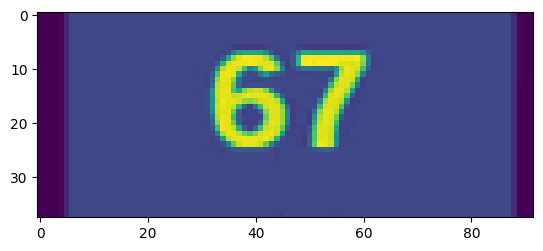

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


img_dir = os.path.join(os.getcwd(), "datasets", "images")
img1_path = os.path.join(img_dir, "image67.png")

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)

img1_shape = np.shape(img1)
print(img1_shape)
plt.imshow(img1)

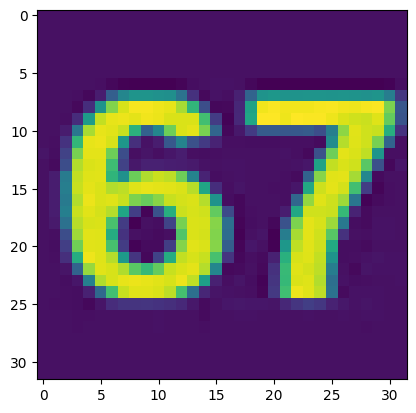

In [3]:
new_img1 = img1[:32, 30:62]
plt.imshow(new_img1)


In [35]:
def crop_image(img_path, n):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img[:32, 30:62]
    outdir = os.path.join(os.getcwd(), "new_images")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outfile = os.path.join(outdir, "image{}.png".format(n))
    cv2.imwrite(outfile, img)

def crop_img2d(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img1 = img[:32, 30:46]
    img2 = img[:32, 46:62]
    # img1 = img[:32, 26:38]
    # img2 = img[:32, 40:58]
    outdir = os.path.join(os.getcwd(), "newer_images")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outfile1 = os.path.join(outdir, "image7_10.png")
    outfile2 = os.path.join(outdir, "image9_6.png")
    cv2.imwrite(outfile1, img1)
    cv2.imwrite(outfile2, img2)

def crop_img3d(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img1 = img[:32, 24:34]
    img2 = img[:32, 34:52]
    img3 = img[:32, 52:68]
    outdir = os.path.join(os.getcwd(), "newer_images")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outfile1 = os.path.join(outdir, "image1_8.png")
    outfile2 = os.path.join(outdir, "image2_6.png")
    outfile3 = os.path.join(outdir, "image1_9.png")
    cv2.imwrite(outfile1, img1)
    cv2.imwrite(outfile2, img2)
    cv2.imwrite(outfile3, img3)

def crop_images():
    img_dir = os.path.join(os.getcwd(), "datasets", "images")
    i = 0
    for fname in os.listdir(img_dir):
        file_path = os.path.join(img_dir, fname)
        crop_image(file_path, i)
        i += 1

img_path = os.path.join(img_dir, "image640.png")
crop_img2d(img_path)

In [57]:
import os
import cv2
import numpy as np


def zero_pad_img(img):
    if np.shape(img) == (32, 16):
        padded_img = np.pad(img, ((30, 30), (38, 38)), mode="constant", constant_values=0)
    elif np.shape(img) == (44, 92):
        padded_img = np.pad(img, ((24, 24), (0, 0)), mode='constant', constant_values=0)
    elif np.shape(img) == (32, 10):
        padded_img = np.pad(img, ((30, 30), (41, 41)), mode='constant', constant_values=0)
    elif np.shape(img) == (32, 18):
        padded_img = np.pad(img, ((30, 30), (37, 37)), mode='constant', constant_values=0)
    elif np.shape(img) == (32, 12):
        padded_img = np.pad(img, ((30, 30), (40, 40)), mode='constant', constant_values=0)
    else:
        raise ValueError("image has unexpexted shape: {}".format(np.shape(img)))
    assert np.shape(padded_img) == (92, 92), "check zero pad function"
    return padded_img

def pad_images():
    new_dir = os.path.join(os.getcwd(), "new_integer_images")
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)

    imgs_dir = os.path.join(os.getcwd(), "integer_images")
    for fname in os.listdir(imgs_dir):
        f = os.path.join(imgs_dir, fname)
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if np.shape(img) != (92, 92):
            img = zero_pad_img(img)
        save_path = os.path.join(new_dir, fname)
        cv2.imwrite(save_path, img)

pad_images()


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_images():
    imgs_dir = os.path.join(os.getcwd(), "integer_image_dataset")
    outdir = os.path.join(os.getcwd(), "integer_images_dataset_small")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for fname in os.listdir(imgs_dir):
        f = os.path.join(imgs_dir, fname)
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (38, 38))
        outfile = os.path.join(outdir, fname)
        cv2.imwrite(outfile, img)

imgs_dir = os.path.join(os.getcwd(), "digit_images_dataset")
print(len(os.listdir(imgs_dir)))

66


In [2]:
import tensorflow as tf
import os


saved_model_dir = os.path.join(os.getcwd(), "models", "saved_models")

model = tf.saved_model.load(saved_model_dir)
print(dir(model))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable_child', '_add_variable_with_custom_getter', '_checkpoint_dependencies', '_default_save_signature', '_deferred_dependencies', '_delete_tracking', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_gather_saveables_for_checkpoint', '_handle_deferred_dependencies', '_lookup_dependency', '_maybe_initialize_trackable', '_name_based_attribute_restore', '_name_based_restores', '_no_dependency', '_object_identifier', '_preload_simple_restoration', '_restore_from_tensors', '_self_name_based_restores', '_self_saveable_object_factories', '_self_setattr_tracking', '_self_unconditional_chec

In [2]:
import tensorflow as tf
import os


data_dir = os.path.join(os.getcwd(), "digit_images_dataset")



train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(92, 92),
  batch_size=32)



Found 70 files belonging to 10 classes.
Using 56 files for training.


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(92, 92),
  batch_size=32)

Found 70 files belonging to 10 classes.


Using 14 files for validation.
